In [1]:
import os
import torch
import sklearn
import numpy as np
import pandas as pd
import pickle as pickle
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import (AutoTokenizer, 
                          AutoConfig, 
                          AutoModelForSequenceClassification, 
                          Trainer, 
                          TrainingArguments, 
                          RobertaConfig, 
                          RobertaTokenizer, 
                          RobertaForSequenceClassification, 
                          BertTokenizer)

2021-09-30 09:28:26.735802: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import sys
import re
import random
import collections
import matplotlib.pyplot as plt
from tqdm import tqdm

## EDA

### Load Data

In [46]:
def preprocessing_dataset(dataset):
    """ 처음 불러온 csv 파일을 원하는 형태의 DataFrame으로 변경 시켜줍니다."""
    subject_entity = []
    object_entity = []
    for i,j in zip(dataset['subject_entity'], dataset['object_entity']):
        i=eval(i)['word']
        j=eval(j)['word']
        subject_entity.append(i)
        object_entity.append(j)
        
    # subject entity : word
    # object entity : word
    out_dataset = pd.DataFrame({'id':dataset['id'], 
                                'sentence':dataset['sentence'],
                                'subject_entity':subject_entity,
                                'object_entity':object_entity,
                                'label':dataset['label'],})
    return out_dataset

In [47]:
def load_data(dataset_dir):
    """ csv 파일을 경로에 맡게 불러 옵니다. """
    # load csv file
    pd_dataset = pd.read_csv(dataset_dir)
    # preprocess Dataframe
    # extract subject and object entity from dataframe
    dataset = preprocessing_dataset(pd_dataset)
    return dataset

In [48]:
# Load DataFrame & Extractin entity
train_df = load_data("../../dataset/train/train.csv")
train_df.head()

,id,sentence,subject_entity,object_entity,label
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,비틀즈,조지 해리슨,no_relation
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,민주평화당,대안신당,no_relation
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,광주FC,한국프로축구연맹,org:member_of
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,아성다이소,박정부,org:top_members/employees
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,요미우리 자이언츠,1967,no_relation


## Subject Kind

In [6]:
train_df = pd.read_csv("../../dataset/train/train.csv")

In [7]:
train_sub = train_df['subject_entity']
train_obj = train_df['object_entity']

In [8]:
sub_list = []
for sub in train_sub :
    sub_type = eval(sub)['type']
    sub_list.append(sub_type)

In [9]:
sub_counter = collections.Counter()
sub_counter.update(sub_list)

In [10]:
obj_list = []
for obj in train_obj :
    obj_type = eval(obj)['type']
    obj_list.append(obj_type)

In [11]:
obj_counter = collections.Counter()
obj_counter.update(obj_list)

In [12]:
sub_counter = dict(sub_counter)
obj_counter = dict(obj_counter)

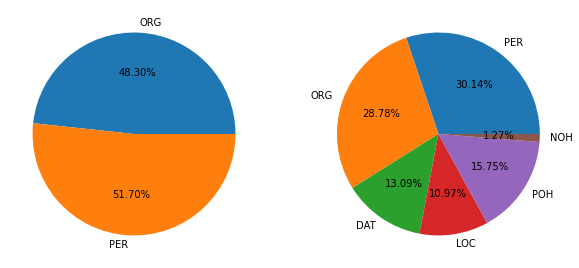

In [13]:
fig, axes = plt.subplots(1, 2, figsize = (10,10))

axes[0].pie(list(sub_counter.values()), 
            labels=list(sub_counter.keys()), 
            autopct='%.2f%%')

axes[1].pie(list(obj_counter.values()), 
            labels=list(obj_counter.keys()),
            autopct='%.2f%%')

plt.show()

In [14]:
# type list ['[ORG]' , '[PER]', '[DAT]' , '[LOC]' ,'[NOH]' , '[POH]', '[CHN]']

In [14]:
train_df['subject_type'] = sub_list
train_df['object_type'] = obj_list

In [15]:
sub_dict = {sub: i for i, sub in enumerate(sub_counter.keys())}
obj_dict = {obj: i for i, obj in enumerate(obj_counter.keys())}

In [16]:
train_df['subject_index'] = train_df['subject_type'].apply(lambda x : sub_dict[x])
train_df['object_index'] = train_df['object_type'].apply(lambda x : obj_dict[x])

In [17]:
train_df.head()

,id,sentence,subject_entity,object_entity,label,source,subject_type,object_type,subject_index,object_index
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia,ORG,PER,0,0
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree,ORG,ORG,0,1
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree,ORG,ORG,0,1
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree,ORG,PER,0,0
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia,ORG,DAT,0,2


In [18]:
train_df.to_csv('../../dataset/train/train_2.csv')

## Class Imbalance

In [19]:
label_list = list(train_df['label'].value_counts().keys())
label_counts = list(train_df['label'].value_counts())    

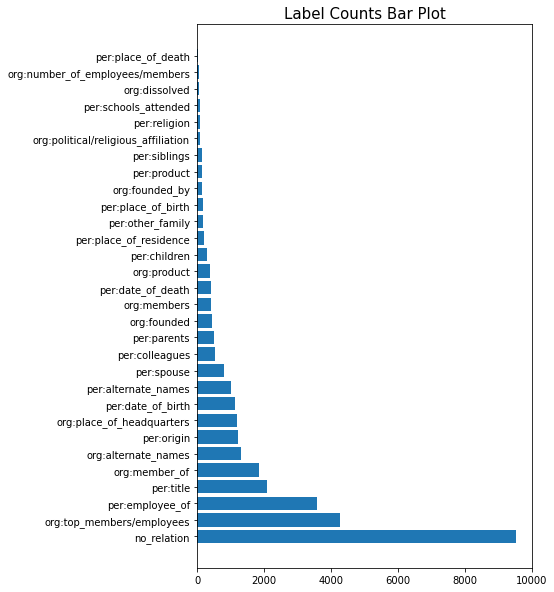

In [20]:
plt.figure(figsize=(6,10))
plt.title('Label Counts Bar Plot', fontsize=15)
plt.barh(label_list, label_counts)
plt.show()

## preprocessing

In [25]:
MODEL_NAME = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [26]:
# extract data from dataframe
def extract_data(dataset) :
    entity_data = []
    sen_data = []
    for e01, e02, s in zip(dataset['subject_entity'], dataset['object_entity'], dataset['sentence']):
        entity_data.append(e01 + ' [SEP] ' + e02)
        sen_data.append(s)
    
    return entity_data, sen_data

In [27]:
entity_data, sen_data = extract_data(train_df)

In [28]:
re_data = [entity_data[i] + ' [SEP] ' + sen_data[i] for i in range(len(train_df))]

In [29]:
len_data = []

for sen in tqdm(re_data) :
    tok_list = tokenizer.tokenize(sen)
    tok_len = len(tok_list)
    len_data.append(tok_len)

100%|██████████| 32470/32470 [00:18<00:00, 1734.84it/s]


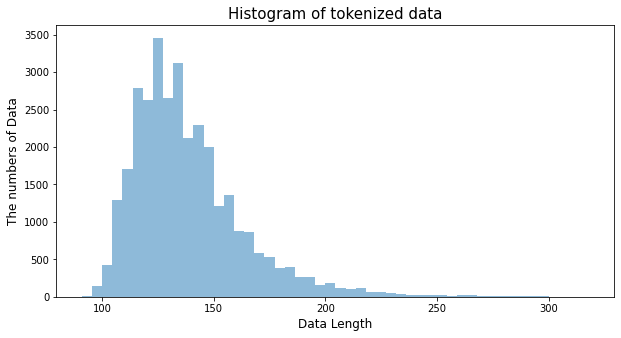

In [30]:
plt.figure(figsize = (10,5))
plt.title('Histogram of tokenized data', fontsize=15)
plt.xlabel('Data Length', fontsize=12)
plt.ylabel('The numbers of Data', fontsize=12)
plt.hist(len_data, alpha=0.5, bins=50)
plt.show()

In [31]:
def get_percent(data_len, thresold) :
    count = 0
    for idx in data_len :
        if idx < thresold :
            count += 1
            
    count /= len(data_len)
    
    print('The percent of Data which length is smaller then (%d) : %.3f' %(thresold, count))

In [32]:
get_percent(len_data, 256)

The percent of Data which length is smaller then (256) : 0.996


## Mecab

In [33]:
from konlpy.tag import Mecab

In [50]:
train_df = load_data("../../dataset/train/train.csv")

In [51]:
mecab = Mecab()

In [52]:
train_sub = list(train_df['subject_entity'])
train_obj = list(train_df['object_entity'])

### Subject

In [53]:
pos_sub = []
for sub in tqdm(train_sub) :
    pos_item = mecab.pos(sub)[0]
    pos_sub.append(pos_item[1])

100%|██████████| 32470/32470 [00:00<00:00, 64059.93it/s]


In [54]:
counter_sub = collections.Counter()
counter_sub.update(pos_sub)
counter_sub = dict(counter_sub)

In [55]:
sub_list = list(counter_sub.keys())
sub_counts = list(counter_sub.values())

### Object

In [57]:
pos_obj = []
for obj in tqdm(train_obj) :
    pos_item = mecab.pos(obj)[0]
    pos_obj.append(pos_item[1])

100%|██████████| 32470/32470 [00:00<00:00, 72322.81it/s]


In [58]:
counter_obj = collections.Counter()
counter_obj.update(pos_obj)
counter_obj = dict(counter_obj)

In [59]:
obj_list = list(counter_obj.keys())
obj_counts = list(counter_obj.values())

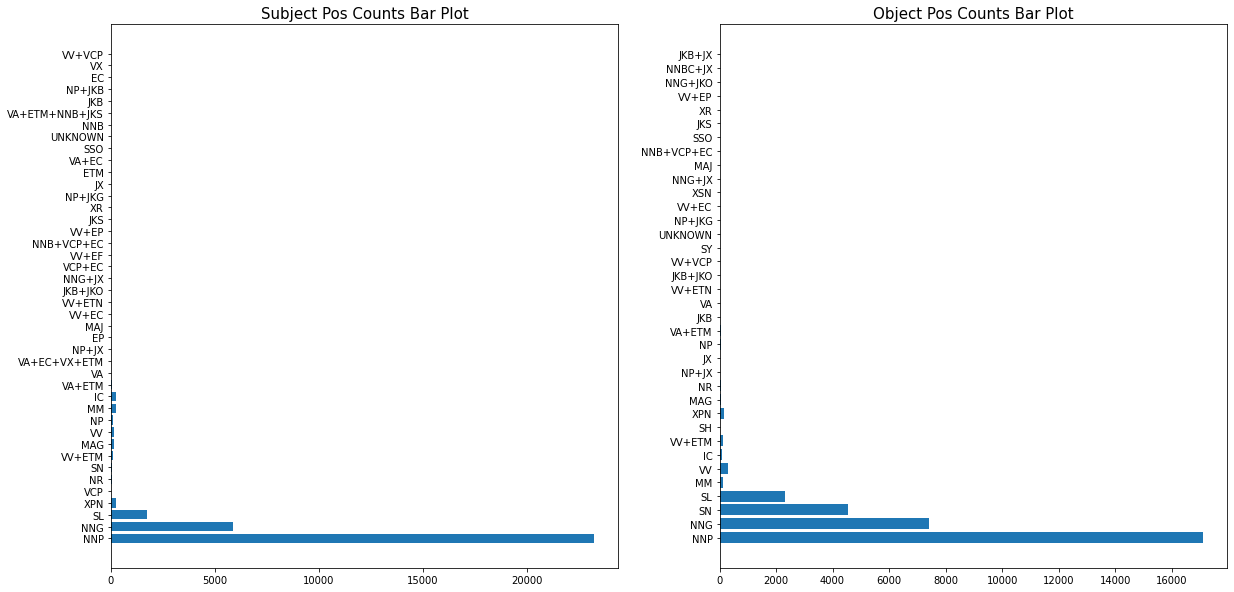

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].set_title('Subject Pos Counts Bar Plot', fontsize=15)
axes[0].barh(sub_list, sub_counts)
axes[1].set_title('Object Pos Counts Bar Plot', fontsize=15)
axes[1].barh(obj_list, obj_counts)
plt.show()

### UNK Token

In [61]:
unk_idx = set()
unk_sub = []

for i, sub in enumerate(tqdm(train_sub)) :
    idx_list = tokenizer.encode(sub)
    if 1 in idx_list :
        unk_sub.append(sub.strip())
        unk_idx.add(i)

100%|██████████| 32470/32470 [00:02<00:00, 13447.56it/s]


In [62]:
print('The number of subject which has UNK : %d' %len(unk_sub))

The number of subject which has UNK : 223


In [63]:
unk_obj = []

for i, obj in enumerate(tqdm(train_obj)) :
    idx_list = tokenizer.encode(obj)
    if 1 in idx_list :
        unk_obj.append(obj.strip())
        unk_idx.add(i)

100%|██████████| 32470/32470 [00:02<00:00, 13600.09it/s]


In [64]:
print('The number of object which has UNK : %d' %len(unk_obj))

The number of object which has UNK : 282


In [65]:
print('Size of Data which has UNK Token(subject & object) : %d' %len(unk_idx))

Size of Data which has UNK Token(subject & object) : 502


In [66]:
unk_idx = sorted(list(unk_idx))
unk_df = train_df.iloc[unk_idx][['subject_entity', 'object_entity']]

In [67]:
unk_df

,subject_entity,object_entity
21,스티브 바라캇,Steve Barakatt
191,쇼니 씨,少弐氏
311,카게야마 슌,가면라이더
358,리셴녠,1909년 6월 23일
374,다마키 고지,玉置浩二
...,...,...
32071,데일리언 앳킨슨,공격수
32131,김헌창,웅진(熊津)
32216,왕원희,문명황후(文明皇后)
32303,미치시타 다이키,홋카이도 제1구


## Special Characters

In [68]:
unk_list = list(unk_sub + unk_obj)

In [69]:
sep_count = 0
sep_list = []

for unk in unk_list :
    if re.search('[가-힣0-9a-zA-Z]', unk) == None :
        sep_list.append(unk)
        sep_count += 1

In [70]:
print('Entity which has only Sepcial Characters : %d' %sep_count)

Entity which has only Sepcial Characters : 88


In [71]:
print('Sepcial Entity \n')

print(sep_list[:10])

Sepcial Entity 

['金基昶', '少弐氏', '玉置浩二', '後北条氏', '伊達氏', 'みゆき', '國稅廳', '株式会社アニメーションドゥウ', '東出昌大', '郭在驥']


### Korean Rare Characters

In [78]:
unk_ch_list = []

In [79]:
for tok in list(unk_df['subject_entity']) :
    tok = re.sub('[^가-힣]', '', tok)
    
    for ch in tok :
        if tokenizer.convert_tokens_to_ids(ch) == 1 :
            unk_ch_list.append(ch)

In [80]:
unk_ch_set = list(set(unk_ch_list))

In [81]:
print('Korean Characters which is not in Tokenizer : %d' %len(unk_ch_set))

Korean Characters which is not in Tokenizer : 83


In [83]:
print(unk_ch_set[:10])

['쿱', '긱', '펍', '귈', '슝', '젬', '푈', '겅', '촐', '훙']


## Special Rare Characters